In [1]:
import itertools
import numpy as np
import torch
import torch.jit
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import sklearn.decomposition
import sklearn.manifold
import sklearn.neighbors
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import polars as pl
import scipy.stats
from mpl_toolkits.axes_grid1 import ImageGrid
import torchinfo

%matplotlib inline

In [2]:
# sim_dir = "/groups/saalfeld/home/allierc/Py/NeuralGraph/graphs_data/fly/fly_N9_54_1"
# use local copy - faster
sim_dir = "/mnt/localdata/fly_N9_54_1"

In [3]:
x = np.load(f"{sim_dir}/x_list_0.npy")

In [4]:
_, num_cells, _ = x.shape
print(x.shape, x.dtype)

(90720, 13741, 9) float32


In [5]:
neuron_types = x[0, :, 6].astype(np.int32)
index_to_name = {0: 'Am', 1: 'C2', 2: 'C3', 3: 'CT1(Lo1)', 4: 'CT1(M10)', 5: 'L1', 6: 'L2',
    7: 'L3', 8: 'L4', 9: 'L5', 10: 'Lawf1', 11: 'Lawf2', 12: 'Mi1', 13: 'Mi10',
    14: 'Mi11', 15: 'Mi12', 16: 'Mi13', 17: 'Mi14', 18: 'Mi15', 19: 'Mi2',
    20: 'Mi3', 21: 'Mi4', 22: 'Mi9', 23: 'R1', 24: 'R2', 25: 'R3', 26: 'R4',
    27: 'R5', 28: 'R6', 29: 'R7', 30: 'R8', 31: 'T1', 32: 'T2', 33: 'T2a',
    34: 'T3', 35: 'T4a', 36: 'T4b', 37: 'T4c', 38: 'T4d', 39: 'T5a', 40: 'T5b',
    41: 'T5c', 42: 'T5d', 43: 'Tm1', 44: 'Tm16', 45: 'Tm2', 46: 'Tm20', 47: 'Tm28',
    48: 'Tm3', 49: 'Tm30', 50: 'Tm4', 51: 'Tm5Y', 52: 'Tm5a', 53: 'Tm5b',
    54: 'Tm5c', 55: 'Tm9', 56: 'TmY10', 57: 'TmY13', 58: 'TmY14', 59: 'TmY15',
    60: 'TmY18', 61: 'TmY3', 62: 'TmY4', 63: 'TmY5a', 64: 'TmY9'
}
neuron_type_name = [
    "Am", "C2", "C3", "CT1(Lo1)", "CT1(M10)",
    "L1", "L2", "L3", "L4", "L5", "Lawf1", "Lawf2",
    "Mi1", "Mi10", "Mi11", "Mi12", "Mi13", "Mi14", "Mi15", "Mi2", "Mi3", "Mi4", "Mi9",
    "R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8",
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm16", "Tm2", "Tm20", "Tm28", "Tm3", "Tm30", "Tm4", "Tm5Y",
    "Tm5a", "Tm5b", "Tm5c", "Tm9", "TmY10", "TmY13", "TmY14",
    "TmY15", "TmY18", "TmY3", "TmY4", "TmY5a", "TmY9"
]
neuron_type_index = {t: i for i, t in enumerate(neuron_type_name)}

def compute_ixs_per_type(neuron_types):
    """Compute indices corresponding to each neuron type."""
    order = np.argsort(neuron_types)
    uniq_types, start_index = np.unique(neuron_types[order], return_index=True)
    num_neuron_types = len(uniq_types)
    assert (uniq_types == np.arange(num_neuron_types)).all(), "breaks assumptions"
    breaks = np.zeros(len(uniq_types)+1, dtype=np.int64)
    breaks[:-1] = start_index
    breaks[-1] = len(neuron_types)
    return [
        order[breaks[i]:breaks[i+1]] for i in range(num_neuron_types)
    ]
neuron_ixs_by_type = compute_ixs_per_type(neuron_types)


In [ ]:
BURNIN_OFFSET = 100
OBS_TIME_STEPS = 20
CA_ACTIVITY_COLUMN = 7


obs_ca = x[BURNIN_OFFSET::OBS_TIME_STEPS, :, CA_ACTIVITY_COLUMN].copy()
train_start = 0
validation_start = 3000
test_start = 3500

train_mat = obs_ca[train_start:validation_start]
val_mat = obs_ca[validation_start:test_start]

In [7]:
from scipy.ndimage import gaussian_filter1d

# Stimulus is only provided to the first 1736 neurons and we hard-code that there
stimulus = gaussian_filter1d(x[BURNIN_OFFSET:, :1736, 4], sigma=OBS_TIME_STEPS / 2)[
    ::OBS_TIME_STEPS
]
stimulus.shape

(4531, 1736)

In [8]:
device = torch.device("cuda")

train_tensor = torch.concatenate(
    [
        torch.tensor(train_mat, device=device),
        torch.tensor(stimulus[train_start:validation_start], device=device),
    ],
    dim=1,
)

In [9]:
# use tf32 math for speed - but perhaps we are sacrificing accuracy in roll out
torch.set_float32_matmul_precision('high')

/home/kumarv4@hhmi.org/miniconda3/envs/neural-graph-linux/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [10]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        num_input_dims: int,
        num_output_dims: int,
        num_hidden_layers: int,
        num_hidden_units: int,
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            torch.nn.init.normal_(linear.weight, mean=0.0, std=0.1)
            torch.nn.init.zeros_(linear.bias)
            self.layers.append(linear)
            self.layers.append(torch.nn.Tanh())
            input_dims = num_hidden_units
        self.layers.append(torch.nn.Linear(num_hidden_units, num_output_dims))

    def forward(self, x):
        y = self.layers[0](x)
        for layer in self.layers[1:-1]:
            y = layer(y)
        return self.layers[-1](y)


class MLPWithResidualConns(torch.nn.Module):
    def __init__(
        self,
        num_input_dims: int,
        num_output_dims: int,
        num_hidden_layers: int,
        num_hidden_units: int,
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            self.layers.append(linear)
            self.layers.append(torch.nn.Tanh())
            input_dims = num_hidden_units
        self.layers.append(torch.nn.Linear(num_hidden_units, num_output_dims))
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.normal_(layer.weight, mean=0.0, std=0.01)
                torch.nn.init.zeros_(layer.bias)

    def forward(self, x):
        y = self.layers[0](x)

        for layer in self.layers[1:-1]:
            y = y + layer(y)

        return self.layers[-1](y)


class Encoder(torch.nn.Module):
    def __init__(self, **mlp_kwargs):
        super().__init__()
        self.mlp = MLPWithResidualConns(**mlp_kwargs)

    def forward(self, x):
        return self.mlp(x)


class Evolver(torch.nn.Module):
    def __init__(self, time_units: int, **mlp_kwargs):
        super().__init__()
        self.time_units = time_units
        self.evolver = MLPWithResidualConns(**mlp_kwargs)

    def forward(self, x):
        for _ in range(self.time_units):
            x = x + self.evolver(x)
        return x


class Decoder(torch.nn.Module):
    def __init__(self, **mlp_kwargs):
        super().__init__()
        self.mlp = MLPWithResidualConns(**mlp_kwargs)

    def forward(self, x):
        return self.mlp(x)

In [11]:

L = 32
# MAX_VALUE = 2.0
encoder = Encoder(
    # max_value=MAX_VALUE,
    num_input_dims=train_tensor.shape[1],
    num_output_dims=L,
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()

decoder = Decoder(
    # max_value=MAX_VALUE,
    num_input_dims=L,
    num_output_dims=train_mat.shape[1],
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()
evolver = Evolver(
    time_units=OBS_TIME_STEPS,
    # max_value=MAX_VALUE,
    num_input_dims=L,
    num_output_dims=L,
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()


# @torch.compile(fullgraph=True, mode="max-autotune")
# def train_encoded_rep(encoder, decoder, train_tensor):
#     proj = encoder(train_tensor)
#     recon = decoder(proj)

#     # reconstruction loss
#     recon_loss = torch.nn.MSELoss()(train_tensor[:, :-1736], recon)

#     loss = recon_loss
#     return loss

# train_encoded_rep_opt = torch.compile(train_encoded_rep, fullgraph=True, mode="reduce-overhead")

@torch.compile(fullgraph=True, mode="reduce-overhead")
def train_with_evolution(encoder, decoder, evolver, train_tensor):

    proj = encoder(train_tensor)
    recon = decoder(proj)

    # remove stimulus piece at the end
    activity = train_tensor[:, :-1736]

    # reconstruction loss
    recon_loss = torch.nn.MSELoss()(activity, recon)


    proj = evolver(proj)
    recon1 = decoder(proj)
    # time steps are nearby
    evolve_loss = torch.nn.MSELoss()(recon1[:-1], activity[1:])

    proj = evolver(proj)
    recon2 = decoder(proj)
    # time steps are nearby
    evolve_loss += torch.nn.MSELoss()(recon2[:-2], activity[2:])

    return evolve_loss, recon_loss
# train_with_evolution_opt = torch.compile(train_with_evolution, fullgraph=True, mode="reduce-overhead")


In [25]:

# # First train encoder/decoder
# opt = torch.optim.Adam(
#     list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
#     lr=1e-3,
# )
# loop = tqdm.trange(10000, ncols=120)
# for i in loop:
#     opt.zero_grad(True)

#     loss = train_encoded_rep(encoder, decoder, evolver, train_tensor)
#     loop.set_postfix(
#         # recon=recon_loss.item(),
#         recon_loss=loss.item(),
#         # lr=f"{scheduler1.get_last_lr()[0]:.3e}"
#     )
#     loss.backward()
#     opt.step()

# now train with the evolver
# First train encoder/decoder
opt = torch.optim.Adam(
    list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
    lr=1e-3,
)
scheduler1 = torch.optim.lr_scheduler.MultiStepLR(
    opt, milestones=[10_000, 30_000], gamma=0.1,
)
# scheduler2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     opt, T_0=100, T_mult=2, eta_min=1e-6
# )
# scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[1000, 10_000], gamma=0.1)
loop = tqdm.trange(50_000, ncols=120)
for i in loop:
    opt.zero_grad(True)

    evolve_loss, recon_loss = train_with_evolution(encoder, decoder, evolver, train_tensor)
    loss = 10.0*evolve_loss + recon_loss
    loop.set_postfix(
        recon=recon_loss.item(),
        evolve_loss=evolve_loss.item(),
        lr=f"{scheduler1.get_last_lr()[0]:.3e}"
    )

    loss.backward()
    opt.step()
    scheduler1.step()
    # scheduler2.step()

100%|███████████████████████████| 50000/50000 [13:35<00:00, 61.28it/s, evolve_loss=0.00348, lr=1.000e-05, recon=0.00101]


In [26]:
# opt = torch.optim.Adam(
#     list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
#     lr=1e-4,
# )
# loop = tqdm.trange(10000, ncols=120)
# for i in loop:
#     opt.zero_grad(True)

#     loss, recon_loss = train_with_evolution(encoder, decoder, evolver, train_tensor)
#     loop.set_postfix(
#         recon=recon_loss.item(),
#         loss=loss.item(),
#         # lr=f"{scheduler1.get_last_lr()[0]:.3e}"
#     )

#     loss.backward()
#     opt.step()

In [27]:
# Save models
# ep = torch.export.export(encoder, (train_tensor,))
# torch.export.save(ep, "/mnt/localdata/encoder.pt2")
# proj = encoder(train_tensor)
# ep = torch.export.export(decoder, (proj,))
# torch.export.save(ep, "/mnt/localdata/decoder.pt2")
# ep = torch.export.export(evolver, (proj,))
# torch.export.save(ep, "/mnt/localdata/evolver.pt2")

In [28]:
val_tensor = torch.concatenate(
    [
        torch.tensor(val_mat, device=device),
        torch.tensor(stimulus[validation_start:test_start], device=device),
    ],
    dim=1,
)

In [29]:
proj = encoder(val_tensor)
recon = decoder(proj)

proj1 = proj.detach().cpu().numpy()
recon1 = recon.detach().cpu().numpy()

In [30]:
x0 = encoder(val_tensor[:1, :])
results = [x0]
for _ in range((val_tensor.shape[0] - 1)):
    prev = results[-1]
    state = prev.detach().clone()
    state = evolver(state)
    results.append(state)
final = decoder(torch.cat(results, dim=0))
final1 = final.detach().cpu().numpy()

In [33]:
final1.shape

(500, 13741)

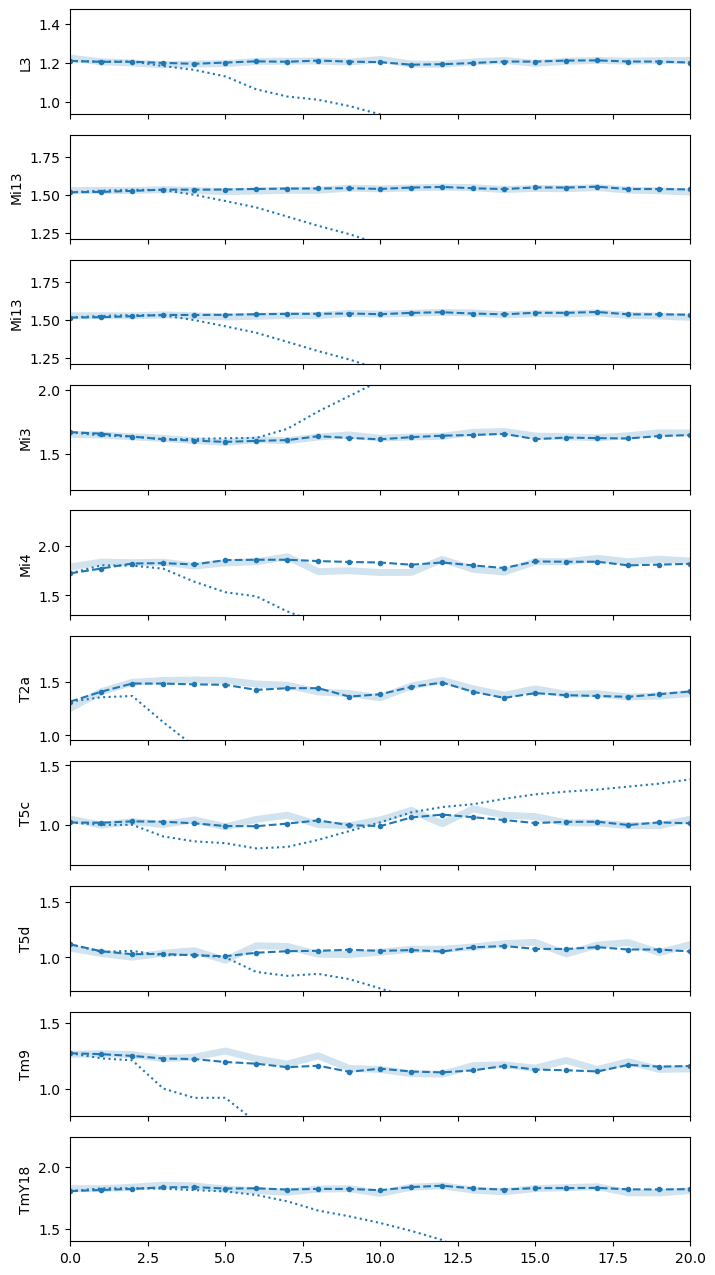

In [55]:

plot_neuron_types = np.sort(np.random.choice(neuron_type_name, 10))
# ['R1', 'R7', 'C2', 'Mi11', 'Tm1', 'Tm4', 'Tm30']

_, ax = plt.subplots(len(plot_neuron_types), 1, figsize=(8, 16), sharex=True)
t0 = 0
T = val_mat.shape[0]
tvals = np.arange(t0, t0 + T)
rng = np.random.default_rng(seed=123)
picks = [rng.choice(nixs) for nixs in neuron_ixs_by_type]

for i, ptype in enumerate(plot_neuron_types):
    nix = picks[neuron_type_index[ptype]]
    true_trace = val_mat[:, nix]
    p = ax[i].plot(tvals, true_trace, lw=5, alpha=0.2)
    ax[i].set_ylim(true_trace.min() * 0.8, true_trace.max() * 1.2)
    # ax[i].set_ylim(1, 2)
    # time evolve
    ax[i].plot(
        tvals,
        final1[:, nix],
        color=p[-1].get_color(),
        ls="dotted",
        label="learn linear evolver",
    )

    ax[i].plot(
        tvals,
        recon1[:, nix],
        color=p[-1].get_color(),
        ls="dashed",
        marker=".",
        label="reconstruct each time point",
    )
    ax[i].set_ylabel(ptype)
plt.xlim(0, 20)
plt.subplots_adjust(hspace=0.2)

In [42]:
delta = (val_mat - final1).astype(np.float64)
val_mat_shuffle = val_mat.copy()
rng = np.random.default_rng(seed=0)
rng.shuffle(val_mat_shuffle, axis=0)
delta_shuffle = val_mat_shuffle - val_mat

delta_constant = val_mat - val_mat[:1]

Text(0.5, 0, 'Time')

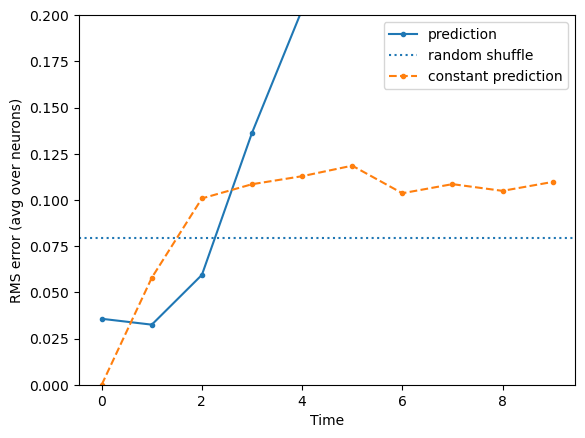

In [43]:
rms_shuffle = np.sqrt(np.power(delta_shuffle, 2).mean(axis=1))
rms_pred =np.sqrt(np.power(delta, 2).mean(axis=1))
rms_constant =np.sqrt(np.power(delta_constant, 2).mean(axis=1))
plt.plot(rms_pred[:10], marker=".", label="prediction")

plt.axhline(rms_shuffle.mean(), ls="dotted", label="random shuffle")
plt.plot(rms_constant[:10], ls="dashed", marker=".", label="constant prediction")
# plt.yscale("log")
plt.ylim(0, 0.2)
plt.legend()
plt.ylabel("RMS error (avg over neurons)")
plt.xlabel("Time")

/home/kumarv4@hhmi.org/miniconda3/envs/neural-graph-linux/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6930: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


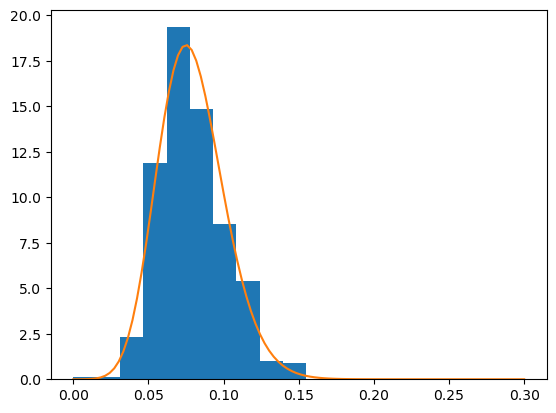

In [94]:
params = scipy.stats.lognorm.fit(rms_shuffle)
plt.hist(rms_shuffle, density=True)
plt.plot(np.linspace(0, 0.3, 100), scipy.stats.lognorm.pdf(np.linspace(0, 0.3, 100), *params))
# pass